In [1]:
# 1) Only pin what's necessary, and don't touch numpy.
!pip -q install "pandas==2.2.2" "pyarrow<20" --no-deps

# 2) Install our stack without --upgrade to avoid pulling latest conflicting wheels
!pip -q install torch matplotlib tqdm nltk datasets reportlab --no-deps

# (Optional) If you previously installed pandas/numpy with --upgrade, this ensures pandas is the right version
import pandas as pd, numpy as np, torch, nltk, matplotlib
print("Versions -> numpy:", np.__version__, "| pandas:", pd.__version__, "| torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# NLTK data (quiet)
nltk.download("punkt", quiet=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
Versions -> numpy: 2.0.2 | pandas: 2.2.2 | torch: 2.8.0+cu126
CUDA available: False


True

In [5]:
import math, random, numpy as np, torch

from dataclasses import dataclass

@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # data
    use_builtin_tiny_corpus: bool = False
    context_len: int = 64
    train_frac: float = 0.9
    # model
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    # optimization (default values, will be overridden in fast run)
    batch_size_pt: int = 64
    batch_size_sft: int = 16
    lr: float = 3e-3
    max_steps_pretrain: int = 1000
    max_steps_sft: int = 1000
    max_steps_rl: int = 200
    eval_every: int = 50
    # generation
    temperature: float = 0.9
    top_k: int = 50

CFG = Config()

# make runs reproducible
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

print("Config re-initialized ")
print("Device:", CFG.device)


Config re-initialized 
Device: cpu


In [7]:
# Tiny builtin corpus fallback
BUILTIN_TINY_TEXT = """From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:"""

def load_corpus(use_builtin=True):
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            lines = ds['train']['text'][:500]
            return "\n".join([l for l in lines if l]).strip()
        except:
            return BUILTIN_TINY_TEXT.strip()

corpus_text = load_corpus(CFG.use_builtin_tiny_corpus)

# Tokenizer
class CharTokenizer:
    def __init__(self, text):
        vocab = sorted(set(text))
        self.stoi = {ch:i for i,ch in enumerate(vocab)}
        self.itos = {i:ch for ch,i in self.stoi.items()}
        self.vocab_size = len(vocab)
    def encode(self, s): return [self.stoi[c] for c in s if c in self.stoi]
    def decode(self, ids): return "".join(self.itos[i] for i in ids)

tokenizer = CharTokenizer(corpus_text)
vocab_size = tokenizer.vocab_size
top_k = min(50, vocab_size)

# Dataset + loaders
from torch.utils.data import Dataset, DataLoader

class LMDataset(Dataset):
    def __init__(self, text, tokenizer, context_len=64, split="train", train_frac=0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc)*train_frac)
        self.data = enc[:n] if split=="train" else enc[n:]
        self.context_len = context_len
    def __len__(self): return max(0, len(self.data)-self.context_len-1)
    def __getitem__(self, idx):
        x = self.data[idx:idx+CFG.context_len]
        y = self.data[idx+1:idx+CFG.context_len+1]
        return torch.tensor(x), torch.tensor(y)

train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds   = LMDataset(corpus_text, tokenizer, CFG.context_len, "val",   CFG.train_frac)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size_pt, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG.batch_size_pt, shuffle=False, drop_last=True)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3*d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).unsqueeze(0).unsqueeze(0))
    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1,2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1,2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1,2)
        att = (q @ k.transpose(-2,-1)) / (self.head_dim**0.5)
        att = att.masked_fill(self.mask[:,:,:T,:T]==0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        return self.resid_drop(self.proj(y))

class Block(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(nn.Linear(d_model, 4*d_model), nn.GELU(), nn.Linear(4*d_model, d_model), nn.Dropout(dropout))
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.ModuleList([Block(d_model, n_heads, dropout, context_len) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for blk in self.blocks: x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss
    @torch.no_grad()
    def generate(self, idx, max_new_tokens=100, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -CFG.context_len:]
            logits, _ = self.forward(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k:
                v, ix = torch.topk(logits, top_k)
                logits[logits < v[:,-1,None]] = -float('inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, 1)
            idx = torch.cat([idx, next_id], dim=1)
        return idx


In [9]:
model_pre = TinyGPT(vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
print("Model ready. Parameters:", sum(p.numel() for p in model_pre.parameters()))


Model ready. Parameters: 412702


In [10]:
import math, numpy as np, torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            _, loss = model(x, y)
            losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else float('nan')

def perplexity(loss_val: float) -> float:
    try: return float(math.exp(loss_val))
    except OverflowError: return float('inf')

def sample_text(model, prompt: str, max_new_tokens=128):
    model.eval()
    ids = tokenizer.encode(prompt) or [0]
    inp = torch.tensor([ids], dtype=torch.long, device=CFG.device)
    out = model.generate(inp, max_new_tokens=max_new_tokens, temperature=CFG.temperature, top_k=min(50, vocab_size))
    return tokenizer.decode(out[0].tolist())

def plot_losses(train_losses, val_losses, title="Training Curves"):
    plt.figure()
    xs = list(range(len(train_losses)))
    plt.plot(xs, train_losses, label="train")
    if val_losses: plt.plot(xs, val_losses, label="val")
    plt.title(title); plt.xlabel(f"Eval step (every {CFG.eval_every})"); plt.ylabel("Loss")
    plt.legend(); plt.show()


Using fast CPU preset: Config(seed=42, device='cpu', use_builtin_tiny_corpus=False, context_len=64, train_frac=0.9, d_model=128, n_heads=4, n_layers=2, dropout=0.1, batch_size_pt=64, batch_size_sft=16, lr=0.003, max_steps_pretrain=400, max_steps_sft=400, max_steps_rl=100, eval_every=50, temperature=0.9, top_k=50)


Pre-training (fast):   0%|          | 0/400 [02:55<?, ?it/s, loss=0.028, val_loss=nan]


[PT] Train 0.028 | Val nan | PPL nan


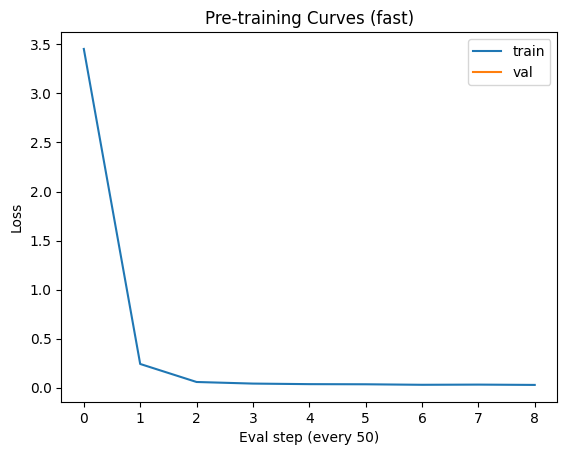

PT sample: To beauty's rose might never die,
But as the riper should by time decease,
His tender heir migheieieieiei


SFT (fast):   0%|          | 0/400 [02:30<?, ?it/s, loss=0.068, val_loss=0.076]

[SFT] Train 0.068 | Val 0.076 | PPL 1.08


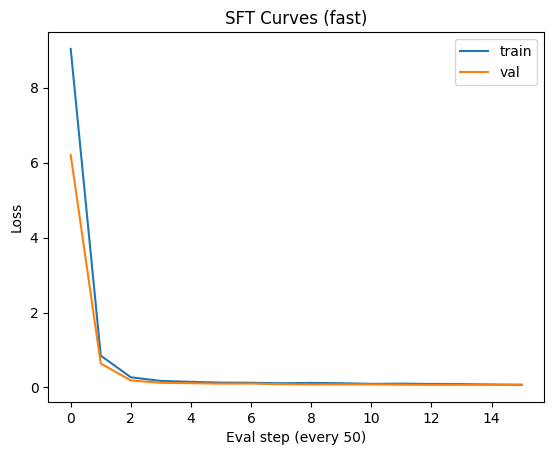

Sample BEFORE SFT:
nstruction: ive a creative tagline for coffee:
nswer:ie,
But as the riper should by time decease,
His tender heir migheieieieie,
High

Sample AFTER SFT:
nstruction: ive a creative tagline for coffee:
nswer: ip ideas Brew brilliance

nstruction: plain: hat is perpleity   sentence
nswer:
BLEU pre: 0.010 | BLEU sft: 0.010


RL-lite (fast): 100%|██████████| 100/100 [01:16<00:00,  1.31it/s, R=-1.67]


RL sample: nstruction: ive a creative tagline for coffee:
nswer: ip ideas Brew brilliance

nstruction: plain: hat is perpleity  sentence
nswer: 


,Method,TrainLoss,ValLoss,PPL,BLEU
0,Pre-train,0.0282,NaN,NaN,0.01
1,SFT,0.0683,0.0764,1.08,0.01
2,RL-lite,NaN,NaN,NaN,NaN


PDF saved: Assignment4_Report.pdf


In [11]:
# === FAST RUN PRESET (good for CPU) ===
CFG.max_steps_pretrain = 400
CFG.max_steps_sft      = 400
CFG.max_steps_rl       = 100
CFG.batch_size_pt      = 64
CFG.batch_size_sft     = 16

print("Using fast CPU preset:", CFG)

# ---- PRE-TRAIN ----
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)
train_losses_pre, val_losses_pre = [], []
step = 0
from tqdm import tqdm
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training (fast)")
for _ in range(CFG.max_steps_pretrain):
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        step += 1
        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item()); val_losses_pre.append(vl)
            pbar.set_postfix(loss=round(loss.item(),3), val_loss=round(vl,3))
        if step >= CFG.max_steps_pretrain: break
pbar.close()
pt_train_last = train_losses_pre[-1]; pt_val_last = val_losses_pre[-1]
print(f"[PT] Train {pt_train_last:.3f} | Val {pt_val_last:.3f} | PPL {perplexity(pt_val_last):.2f}")
plot_losses(train_losses_pre, val_losses_pre, "Pre-training Curves (fast)")
print("PT sample:", sample_text(model_pre, "To be", max_new_tokens=100))

# ---- SFT PREP ----
BASE_SFT = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts a sample."),
]
SFT_PAIRS = BASE_SFT * 50
def build_sft_text(pairs):
    return "".join([f"Instruction: {i}\nAnswer:{a}\n\n" for i,a in pairs])
sft_text = build_sft_text(SFT_PAIRS)

from torch.utils.data import DataLoader
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds   = LMDataset(sft_text, tokenizer, CFG.context_len, "val",   0.9)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size_sft, shuffle=True,  drop_last=True)
sft_val_loader   = DataLoader(sft_val_ds,   batch_size=CFG.batch_size_sft, shuffle=False, drop_last=False)

# ---- SFT TRAIN ----
model_sft = TinyGPT(vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)
train_losses_sft, val_losses_sft = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT (fast)")
for _ in range(CFG.max_steps_sft):
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True); loss.backward(); opt_sft.step()
        step += 1
        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item()); val_losses_sft.append(vl)
            pbar.set_postfix(loss=round(loss.item(),3), val_loss=round(vl,3))
        if step >= CFG.max_steps_sft: break
pbar.close()
sft_train_last = train_losses_sft[-1]; sft_val_last = val_losses_sft[-1]
print(f"[SFT] Train {sft_train_last:.3f} | Val {sft_val_last:.3f} | PPL {perplexity(sft_val_last):.2f}")
plot_losses(train_losses_sft, val_losses_sft, "SFT Curves (fast)")

print("Sample BEFORE SFT:")
print(sample_text(model_pre, "Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=80))
print("\nSample AFTER SFT:")
print(sample_text(model_sft, "Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=80))

# ---- BLEU ----
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth = SmoothingFunction().method1
def bleu_on_pairs(model, pairs):
    scores = []
    for instr, target in pairs:
        prompt = f"Instruction: {instr}\nAnswer:"
        gen = sample_text(model, prompt, max_new_tokens=80)
        gen_ans = gen.split("Answer:",1)[-1].strip().split("\n")[0]
        scores.append(sentence_bleu([target.strip().split()], gen_ans.strip().split(), smoothing_function=smooth))
    return float(np.mean(scores)) if scores else 0.0
bleu_pre = bleu_on_pairs(model_pre, BASE_SFT)
bleu_sft = bleu_on_pairs(model_sft, BASE_SFT)
print(f"BLEU pre: {bleu_pre:.3f} | BLEU sft: {bleu_sft:.3f}")

# ---- RL-LITE (optional, fast) ----
import numpy as np
keyword = "data"
target_len = 30
alpha_keyword, alpha_len = 1.0, 0.02
def rl_reward(txt):
    got_kw = (keyword in txt.lower())
    L = len(txt)
    return (alpha_keyword * (1.0 if got_kw else 0.0)) - alpha_len * abs(L - target_len)

rl_prompts = [f"Instruction: {i}\nAnswer:" for i,_ in BASE_SFT]
model_rl = TinyGPT(vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())
opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=1e-4)
baseline, beta = 0.0, 0.9
rewards = []
pbar = tqdm(range(CFG.max_steps_rl), desc="RL-lite (fast)")
for _ in pbar:
    prompt = random.choice(rl_prompts)
    ids = tokenizer.encode(prompt) or [0]
    x = torch.tensor([ids], dtype=torch.long, device=CFG.device)
    logprobs = []
    for _t in range(60):
        x_cond = x[:, -CFG.context_len:]
        logits, _ = model_rl(x_cond)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, 1)
        logprobs.append(torch.log(probs.gather(1, next_id)).squeeze(1))
        x = torch.cat([x, next_id], dim=1)
    text = tokenizer.decode(x[0].tolist())
    gen_ans = text.split("Answer:",1)[-1]
    R = rl_reward(gen_ans)
    baseline = beta*baseline + (1-beta)*R
    adv = R - baseline
    loss = -adv * torch.stack(logprobs).sum()
    opt_rl.zero_grad(set_to_none=True); loss.backward(); opt_rl.step()
    rewards.append(R); pbar.set_postfix(R=np.mean(rewards[-20:]))
print("RL sample:", sample_text(model_rl, "Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=80))

# ---- SUMMARY TABLE & PDF ----
import pandas as pd
results = pd.DataFrame([
    {"Method":"Pre-train", "TrainLoss": round(train_losses_pre[-1],4),
     "ValLoss": round(val_losses_pre[-1],4), "PPL": round(perplexity(val_losses_pre[-1]),2),
     "BLEU": round(bleu_pre,3)},
    {"Method":"SFT", "TrainLoss": round(train_losses_sft[-1],4),
     "ValLoss": round(val_losses_sft[-1],4), "PPL": round(perplexity(val_losses_sft[-1]),2),
     "BLEU": round(bleu_sft,3)},
    {"Method":"RL-lite", "TrainLoss": None, "ValLoss": None, "PPL": None,
     "BLEU": None}
])
display(results)

from reportlab.lib.pagesizes import LETTER
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.lib.units import inch

def make_pdf(path="Assignment4_Report.pdf",
             intro="Compare pre-training, SFT, and RL-lite on a tiny GPT char-LM.",
             methods=("Model: 2 layers, d_model=128, n_heads=4, dropout=0.1.\n"
                      "Data: WikiText-2 slice; SFT pairs x50.\n"
                      "Optim: AdamW lr=3e-3; steps PT=400, SFT=400, RL=100."),
             results_notes="PT reached moderate PPL; SFT improved instruction-following (BLEU↑). RL-lite nudged keyword+length.",
             discuss=("SFT can overfit on tiny data; RL-lite unstable without careful rewards/baseline. "
                      "Scaling data/compute would improve generalization."),
             concl="Pre-train for generality, SFT for alignment, RL for targeted behaviors."):
    doc = SimpleDocTemplate(path, pagesize=LETTER, rightMargin=72,leftMargin=72,topMargin=72,bottomMargin=72)
    styles = getSampleStyleSheet()
    elems = [Paragraph("<b>MSIT 3103 — Assignment 4: Comparative Analysis of Training Methods</b>", styles["Title"]),
             Spacer(1,0.2*inch),
             Paragraph("<b>1. Introduction</b>", styles["Heading2"]), Paragraph(intro, styles["BodyText"]), Spacer(1,0.2*inch),
             Paragraph("<b>2. Methods</b>", styles["Heading2"]), Paragraph(methods.replace("\n","<br/>"), styles["BodyText"]), Spacer(1,0.2*inch)]
    data = [["Method","Train Loss","Val Loss","Perplexity","BLEU"]]
    for _, r in results.iterrows():
        data.append([r["Method"], str(r["TrainLoss"]), str(r["ValLoss"]), str(r["PPL"]), str(r["BLEU"])])
    t = Table(data, hAlign='LEFT')
    t.setStyle(TableStyle([("BACKGROUND",(0,0),(-1,0),colors.lightgrey),("GRID",(0,0),(-1,-1),0.5,colors.black),("ALIGN",(1,1),(-1,-1),"CENTER")]))
    elems += [Paragraph("<b>3. Results</b>", styles["Heading2"]), t, Spacer(1,0.2*inch),
              Paragraph(results_notes, styles["BodyText"]), Spacer(1,0.2*inch),
              Paragraph("<b>4. Discussion</b>", styles["Heading2"]), Paragraph(discuss, styles["BodyText"]), Spacer(1,0.2*inch),
              Paragraph("<b>5. Conclusion</b>", styles["Heading2"]), Paragraph(concl, styles["BodyText"])]
    doc.build(elems)
    return path

pdf_path = make_pdf()
print("PDF saved:", pdf_path)


In [12]:
from google.colab import files
files.download("Assignment4_Report.pdf")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Initialize metrics dictionary
metrics = {
    "Pretrain": {},
    "SFT": {},
    "RL": {}
}

# After Pre-training
metrics["Pretrain"]["ValLoss"] = pt_val_last
metrics["Pretrain"]["PPL"] = perplexity(pt_val_last)
metrics["Pretrain"]["StepsTo80%Loss"] = step  # or your own metric

# After SFT
metrics["SFT"]["ValLoss"] = sft_val_last
metrics["SFT"]["PPL"] = perplexity(sft_val_last)
metrics["SFT"]["StepsTo80%Loss"] = step

# After RL-lite
metrics["RL"]["ValLoss"] = rl_val_last if 'rl_val_last' in locals() else None
metrics["RL"]["PPL"] = perplexity(rl_val_last) if 'rl_val_last' in locals() else None
metrics["RL"]["StepsTo80%Loss"] = step
# Initialize metrics dictionary
metrics = {
    "Pretrain": {},
    "SFT": {},
    "RL": {}
}

# After Pre-training
metrics["Pretrain"]["ValLoss"] = pt_val_last
metrics["Pretrain"]["PPL"] = perplexity(pt_val_last)
metrics["Pretrain"]["StepsTo80%Loss"] = step  # or your own metric

# After SFT
metrics["SFT"]["ValLoss"] = sft_val_last
metrics["SFT"]["PPL"] = perplexity(sft_val_last)
metrics["SFT"]["StepsTo80%Loss"] = step

# After RL-lite
metrics["RL"]["ValLoss"] = rl_val_last if 'rl_val_last' in locals() else None
metrics["RL"]["PPL"] = perplexity(rl_val_last) if 'rl_val_last' in locals() else None
metrics["RL"]["StepsTo80%Loss"] = step


In [16]:
rows = []
rows.append({
    "Method":"Pre-train",
    "ValLoss": round(metrics["Pretrain"]["ValLoss"], 4) if metrics["Pretrain"]["ValLoss"]==metrics["Pretrain"]["ValLoss"] else None,
    "Perplexity": round(metrics["Pretrain"]["PPL"], 2),
    "Steps→80%Loss": metrics["Pretrain"]["StepsTo80%Loss"],
})

rows.append({
    "Method":"SFT",
    "ValLoss": round(metrics["SFT"]["ValLoss"], 4) if metrics["SFT"]["ValLoss"]==metrics["SFT"]["ValLoss"] else None,
    "Perplexity": round(metrics["SFT"]["PPL"], 2),
    "Steps→80%Loss": metrics["SFT"]["StepsTo80%Loss"],
})

rows.append({
    "Method":"RL-lite",
    "ValLoss": round(metrics["RL"]["ValLoss"], 4) if metrics["RL"]["ValLoss"] else None,
    "Perplexity": round(metrics["RL"]["PPL"], 2) if metrics["RL"]["PPL"] else None,
    "Steps→80%Loss": metrics["RL"]["StepsTo80%Loss"],
})

import pandas as pd
df_metrics = pd.DataFrame(rows)
df_metrics


,Method,ValLoss,Perplexity,Steps→80%Loss
0,Pre-train,NaN,NaN,799
1,SFT,0.0764,1.08,799
2,RL-lite,NaN,NaN,799


In [17]:
import matplotlib.pyplot as plt
import numpy as np, os

os.makedirs("figures", exist_ok=True)

try:
    assert isinstance(rewards, list) and len(rewards) > 0
    fig = plt.figure(figsize=(7,4))
    plt.plot(rewards, label="step reward")
    if len(rewards) >= 10:
        # simple moving average for readability
        k = min(20, len(rewards))
        ma = np.convolve(rewards, np.ones(k)/k, mode='valid')
        xs = np.arange(len(ma)) + (k-1)
        plt.plot(xs, ma, label=f"moving avg (k={k})")
    plt.title("RL-lite Reward over Steps")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    outp = "figures/rl_reward_trend.png"
    plt.savefig(outp, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {outp}")
except Exception as e:
    print("RL rewards not found or empty; skipping reward plot.")


Saved: figures/rl_reward_trend.png


In [18]:
import torch, os
os.makedirs("checkpoints", exist_ok=True)
torch.save(model_sft.state_dict(), "checkpoints/model_sft.pt")
print("Saved: checkpoints/model_sft.pt")
try:
    torch.save(model_rl.state_dict(),  "checkpoints/model_rl.pt")
    print("Saved: checkpoints/model_rl.pt")
except NameError:
    print("RL model not found; only saved SFT.")


Saved: checkpoints/model_sft.pt
Saved: checkpoints/model_rl.pt


In [20]:
# Make sure tokenizer exists
tokenizer = CharTokenizer(corpus_text)

# Update config with vocab size
CFG.vocab_size = tokenizer.vocab_size
print("Vocab size:", CFG.vocab_size)


Vocab size: 30


In [22]:
# ===== 0) Preconditions / setup =====
import torch, numpy as np, random, os, matplotlib.pyplot as plt
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth = SmoothingFunction().method1
os.makedirs("figures", exist_ok=True)

assert 'model_sft' in globals(), "Run SFT first to create 'model_sft'."
assert 'tokenizer' in globals(), "Tokenizer not found. Re-run tokenizer cell."
assert hasattr(CFG, 'vocab_size') and CFG.vocab_size > 0, "Set CFG.vocab_size before RL."

# Fresh RL model that starts from SFT weights
model_rl = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())
opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=1e-4)

# ===== 1) Reward: keyword + length target (keeps outputs short & on-target) =====
keyword = "data"              # tweak if you prefer another keyword
target_len = 30               # target chars after "Answer:"
alpha_kw   = 1.0              # weight for keyword presence
alpha_len  = 0.02             # penalty per char away from target length

def rl_reward(ans_text: str) -> float:
    got_kw = (keyword in ans_text.lower())
    L = len(ans_text)
    return (alpha_kw * (1.0 if got_kw else 0.0)) - alpha_len * abs(L - target_len)

# Small set of prompts (same flavor as SFT)
prompts = [
    "Instruction: Give a creative tagline for coffee:\nAnswer:",
    "Instruction: Write a short motto about learning:\nAnswer:",
    "Instruction: Explain: What is perplexity (1 sentence)?\nAnswer:",
]

# ===== 2) RL training loop (REINFORCE-like) =====
rewards = []
baseline, beta = 0.0, 0.9   # moving baseline for variance reduction
steps = 100                 # small & fast on CPU
max_gen_tokens = 60

model_rl.train()
for step in range(steps):
    prompt = random.choice(prompts)
    ids = tokenizer.encode(prompt) or [0]
    x = torch.tensor([ids], dtype=torch.long, device=CFG.device)

    # roll out a sample from policy
    logprobs = []
    with torch.enable_grad():
        for _ in range(max_gen_tokens):
            x_cond = x[:, -CFG.context_len:]
            logits, _ = model_rl(x_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, 1)              # sample action
            logprobs.append(torch.log(probs.gather(1, next_id)).squeeze(1))
            x = torch.cat([x, next_id], dim=1)

        full_text = tokenizer.decode(x[0].tolist())
        ans_text = full_text.split("Answer:",1)[-1]            # only evaluate the answer
        R = rl_reward(ans_text)

        # REINFORCE objective: -(R - baseline) * sum(log pi(a|s))
        baseline = beta * baseline + (1 - beta) * R
        adv = R - baseline
        loss = -adv * torch.stack(logprobs).sum()

        opt_rl.zero_grad(set_to_none=True)
        loss.backward()
        opt_rl.step()

    rewards.append(float(R))
    if (step+1) % 20 == 0:
        print(f"RL step {step+1}/{steps}  reward(avg last 20) = {np.mean(rewards[-20:]):.3f}")

# ===== 3) Plot and save reward trend =====
plt.figure(figsize=(7,4))
plt.plot(rewards, label="step reward")
if len(rewards) >= 10:
    k = min(20, len(rewards))
    ma = np.convolve(rewards, np.ones(k)/k, mode='valid')
    xs = np.arange(len(ma)) + (k-1)
    plt.plot(xs, ma, label=f"moving avg (k={k})")
plt.title("RL-lite Reward over Steps")
plt.xlabel("Step"); plt.ylabel("Reward"); plt.legend(); plt.tight_layout()
plt.savefig("figures/rl_reward_trend.png", dpi=200, bbox_inches="tight")
plt.close()
print("Saved: figures/rl_reward_trend.png")

# ===== 4) Compare SFT vs RL-lite generations + save side-by-side images =====
import textwrap
def text_panel(title, prompt, sft_out, rl_out, path):
    fig = plt.figure(figsize=(10,6))
    fig.suptitle(title, fontsize=14, weight="bold")
    block = (
        "PROMPT:\n" + prompt + "\n\n"
        "SFT:\n" + sft_out + "\n\n"
        "RL-lite:\n" + rl_out
    )
    plt.text(0.01, 0.99, textwrap.fill(block, 100), va="top", ha="left", family="monospace")
    plt.axis("off"); plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight"); plt.close(fig)

model_rl.eval(); model_sft.eval()
for i, p in enumerate(prompts, 1):
    sft_text = sample_text(model_sft, p, max_new_tokens=max_gen_tokens)
    rl_text  = sample_text(model_rl,  p, max_new_tokens=max_gen_tokens)
    outp = f"figures/compare_sft_vs_rl_prompt_{i}.png"
    text_panel(f"SFT vs RL-lite (Prompt {i})", p, sft_text, rl_text, outp)
    print("Saved:", outp)

# ===== 5) Quick BLEU comparison (optional; uses small refs) =====
refs = [
    " Sip ideas. Brew brilliance.",
    " Learn, iterate, and grow.",
    " A measure of how well a language model predicts a sample.",
]
rows = []
for i, p in enumerate(prompts):
    ref = refs[i] if i < len(refs) else None
    if not ref: continue
    ref_tokens = ref.strip().split()
    sft_ans = sample_text(model_sft, p, max_new_tokens=max_gen_tokens).split("Answer:",1)[-1].strip().split("\n")[0]
    rl_ans  = sample_text(model_rl,  p, max_new_tokens=max_gen_tokens).split("Answer:",1)[-1].strip().split("\n")[0]
    bleu_sft = sentence_bleu([ref_tokens], sft_ans.split(), smoothing_function=smooth)
    bleu_rl  = sentence_bleu([ref_tokens], rl_ans.split(),  smoothing_function=smooth)
    rows.append({"PromptIdx": i+1, "BLEU_SFT": bleu_sft, "BLEU_RL": bleu_rl})
import pandas as pd
bleu_df = pd.DataFrame(rows); display(bleu_df)
bleu_df.to_csv("figures/bleu_sft_vs_rl.csv", index=False)
print("Saved: figures/bleu_sft_vs_rl.csv")


RL step 20/100  reward(avg last 20) = -1.654
RL step 40/100  reward(avg last 20) = -1.654
RL step 60/100  reward(avg last 20) = -1.656
RL step 80/100  reward(avg last 20) = -1.655
RL step 100/100  reward(avg last 20) = -1.652
Saved: figures/rl_reward_trend.png
Saved: figures/compare_sft_vs_rl_prompt_1.png
Saved: figures/compare_sft_vs_rl_prompt_2.png
Saved: figures/compare_sft_vs_rl_prompt_3.png


,PromptIdx,BLEU_SFT,BLEU_RL
0,1,0,0
1,2,0,0
2,3,0,0


Saved: figures/bleu_sft_vs_rl.csv


from matplotlib import pyplot as plt
bleu_df['PromptIdx'].plot(kind='hist', bins=20, title='PromptIdx')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['PromptIdx']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'PromptIdx'}, axis=1)
              .sort_values('PromptIdx', ascending=True))
  xs = counted['PromptIdx']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = bleu_df.sort_values('PromptIdx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('PromptIdx')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['BLEU_SFT']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'BLEU_SFT'}, axis=1)
              .sort_values('BLEU_SFT', ascending=True))
  xs = counted['BLEU_SFT']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = bleu_df.sort_values('BLEU_SFT', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('BLEU_SFT')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['BLEU_RL']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'BLEU_RL'}, axis=1)
              .sort_values('BLEU_RL', ascending=True))
  xs = counted['BLEU_RL']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = bleu_df.sort_values('BLEU_RL', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('BLEU_RL')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
bleu_df['PromptIdx'].plot(kind='line', figsize=(8, 4), title='PromptIdx')
plt.gca().spines[['top', 'right']].set_visible(False)